### Notebook to do inference on a new image

In [48]:
# Load
import torch
from lightning import Trainer
from torch.utils.data import DataLoader
import numpy as np
from scipy.ndimage import zoom
from src.data.dataset import Dataset
from src.modules.lightning_cnn import LitCNN
from src.utils.optimization import Optimization
import nibabel as nib
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt


MODEL_PATH = r"/home/ubuntu/giorgio/v311/lightning_logs/brain_model/version_111/checkpoints/epoch=29-step=180.ckpt"
IMG_PATH = r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/goundtruth_testBosisio/goundtruth/sub-010_dseg_warped_0.5mm.nii.gz"
MRI_PATH = r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/MRI_testBosisio/images/sub-010_brain_warped_0.5mm.nii.gz"

def resize(array: np.array,) :
    target_shape = (128, 128, 128)

    # Calculate zoom factors
    original_shape = array.shape
    zoom_factors = [t / o for t, o in zip(target_shape, original_shape)]

    # Resize the array using nearest-neighbor interpolation
    resized_array = zoom(array, zoom_factors, order=0)  # 'order=0' for nearest-neighbor interpolation
    return resized_array

def reshape_output(
    y_hat: torch.Tensor,
) -> torch.Tensor:
    """
    Reshape the output tensor (1,30) of the model to the (10,3) model.

    Parameters:
    - y_hat (torch.Tensor): Predicted tensor (1,30) from the model.

    Returns:
    - torch.Tensor: output tensor with resized shape.

    """
    y_hat_new = y_hat.cpu().data.numpy()
    y_hat_new = y_hat_new.reshape(10,3)

    return y_hat_new

In [49]:
def import_img(IMG_PATH:str, MRI_PATH:str):
    raw_img = nib.load(IMG_PATH)
    my_img = raw_img.get_fdata()
    raw_MRI = nib.load(MRI_PATH)
    my_MRI = raw_MRI.get_fdata()
    resized_img = resize(my_img)
    resized_MRI = resize(my_MRI)
    resized_img=np.expand_dims(resized_img, axis=0)
    resized_img=np.expand_dims(resized_img, axis=0)
    # Verify the result
    print(resized_img.shape)
    return resized_img, resized_MRI

resized_img, resized_MRI = import_img(IMG_PATH, MRI_PATH) 

(brains,
    y_reg,
    predict_index,
) = tuple(
    map(
        torch.Tensor,
        (
            resized_img,
            [np.ones(30)],
            1,
        ),
    )
)
pred_dataset = TensorDataset(
    brains,
    y_reg,
    predict_index,
)

dataset = pred_dataset
lightning_cnn = LitCNN.load_from_checkpoint(checkpoint_path=MODEL_PATH)

prediction_loader = DataLoader(
    dataset,
    num_workers=0,
)

trainer = Trainer(logger=False)

biometry=trainer.predict(lightning_cnn, dataloaders=prediction_loader, return_predictions=True)
biometry=reshape_output(biometry[0])
old_bio=biometry

(1, 1, 128, 128, 128)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.85it/s]


In [50]:
biometry

array([[ 63.729424 ,  89.34951  ,  65.35711  ],
       [ 63.889248 ,  57.20888  ,  69.78078  ],
       [ 62.299847 ,  39.745316 ,  26.581955 ],
       [ 62.489975 ,  43.02629  ,  44.245525 ],
       [109.790146 ,  57.35505  ,  70.91209  ],
       [ 15.3612585,  57.89587  ,  69.11981  ],
       [  6.472076 ,  66.91774  ,  67.86211  ],
       [119.00815  ,  62.992653 ,  65.15059  ],
       [ 84.21339  ,  41.39955  ,  30.52041  ],
       [ 39.96     ,  42.222195 ,  31.032873 ]], dtype=float32)

### Per visualizzare i risultati

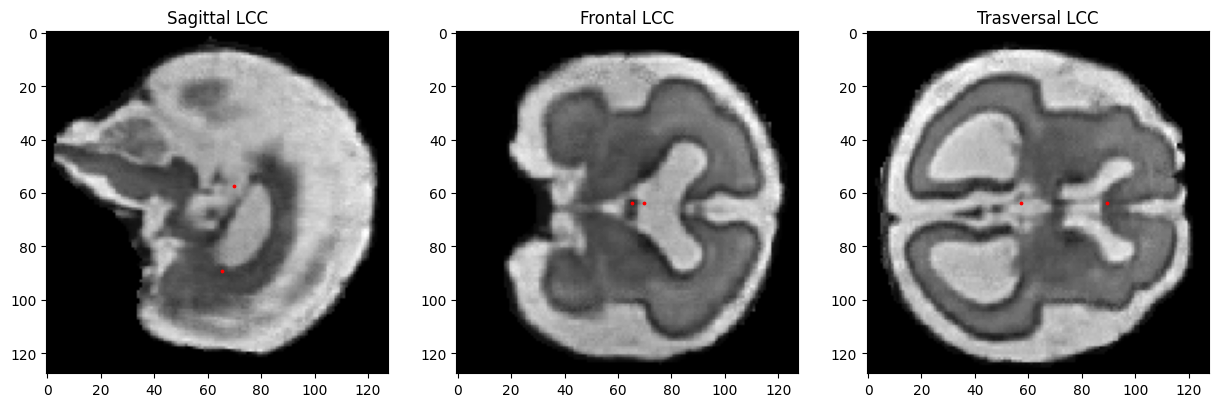

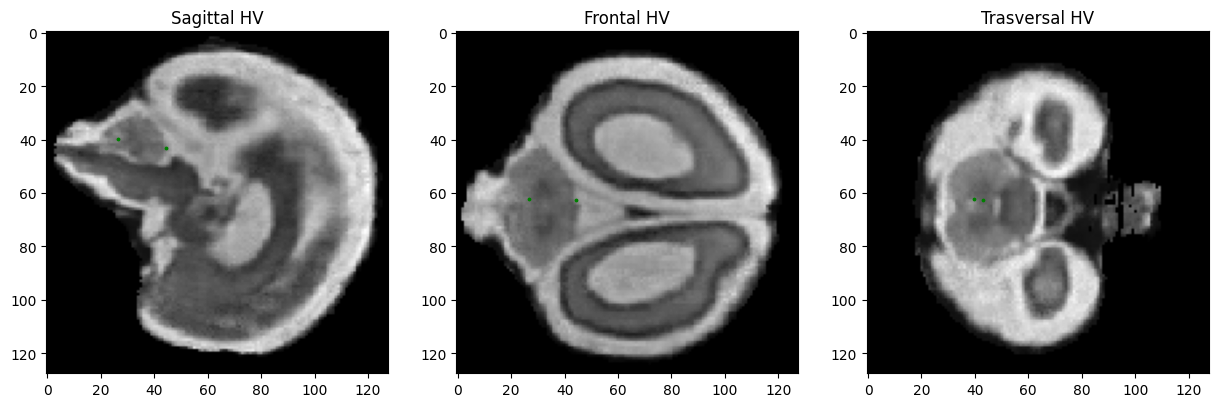

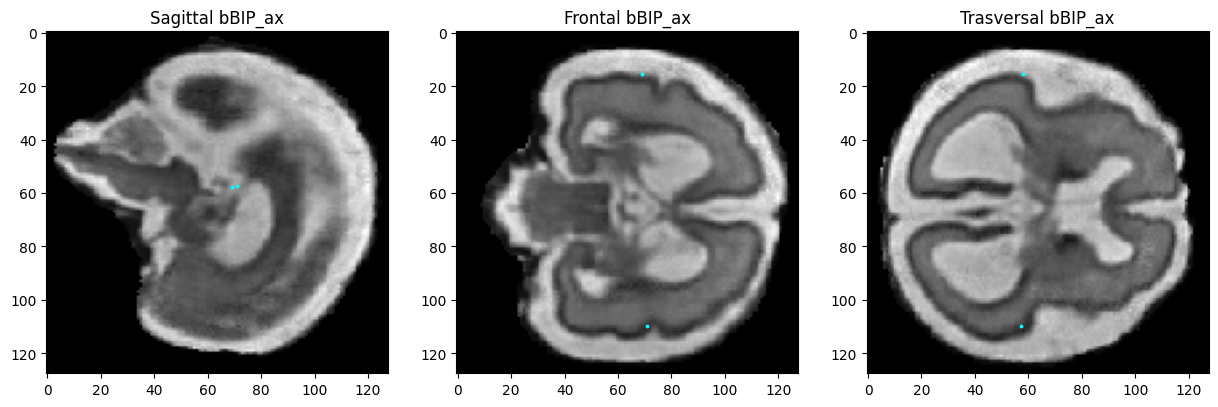

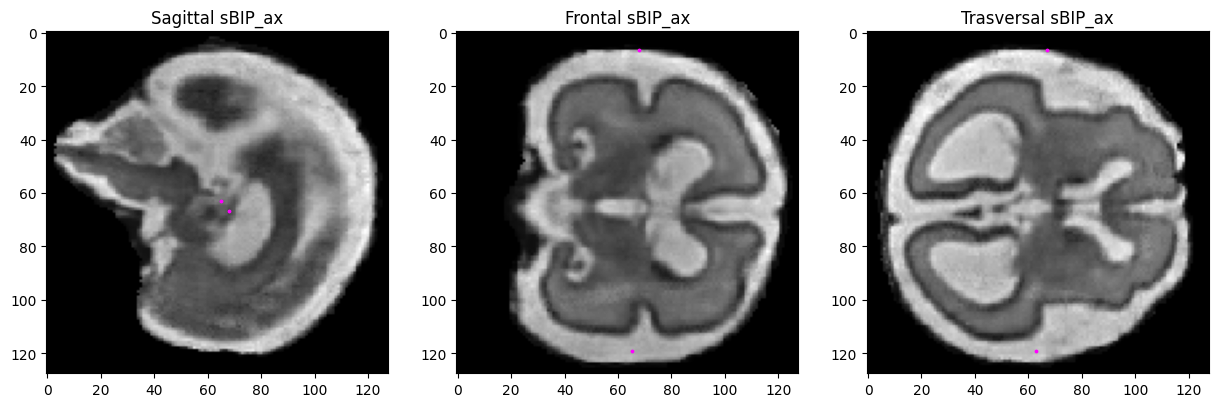

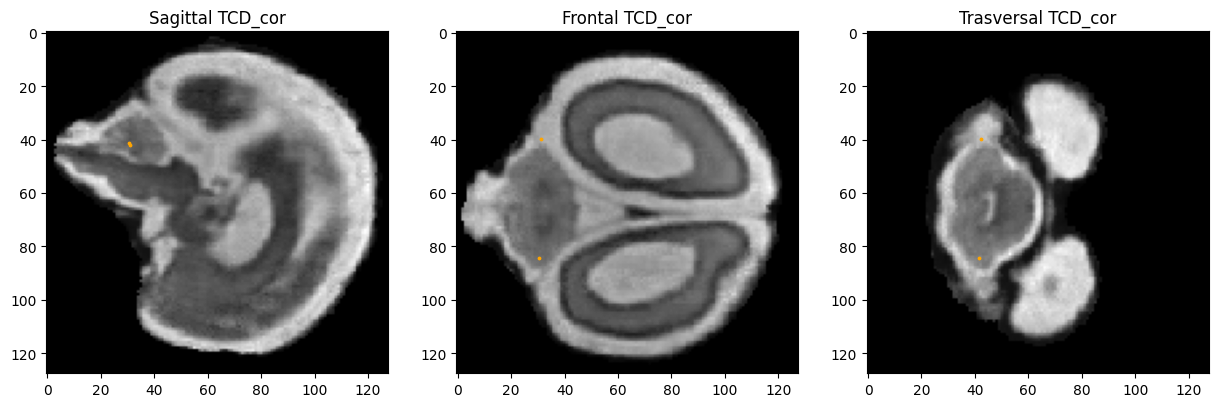

In [51]:
import matplotlib.pyplot as plt

x_positions, y_positions, z_positions = biometry[:,0],biometry[:,1],biometry[:,2]
visualize=resized_MRI

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()

### Fase di ottimizzazione

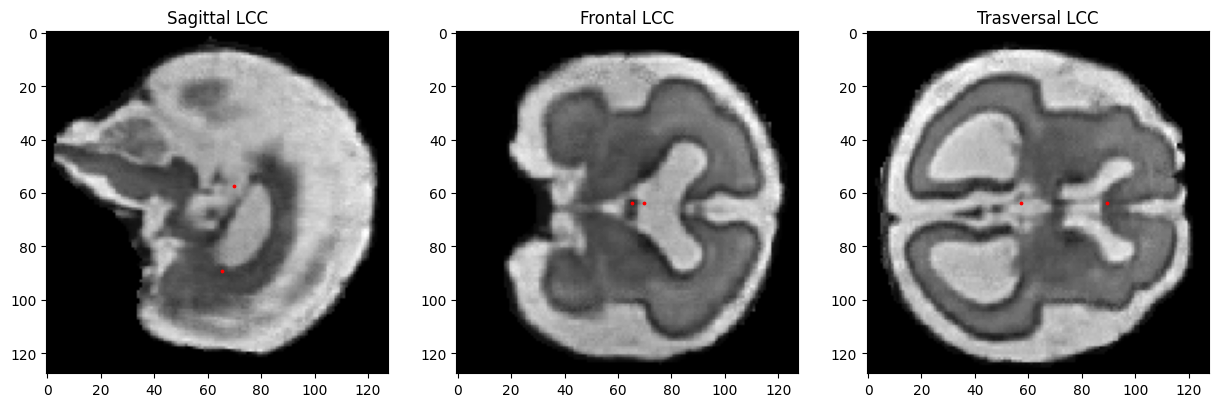

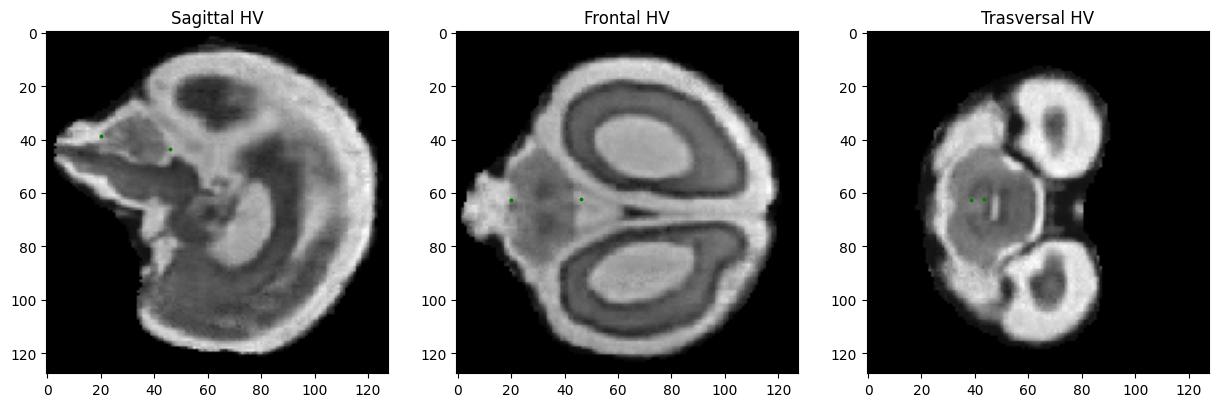

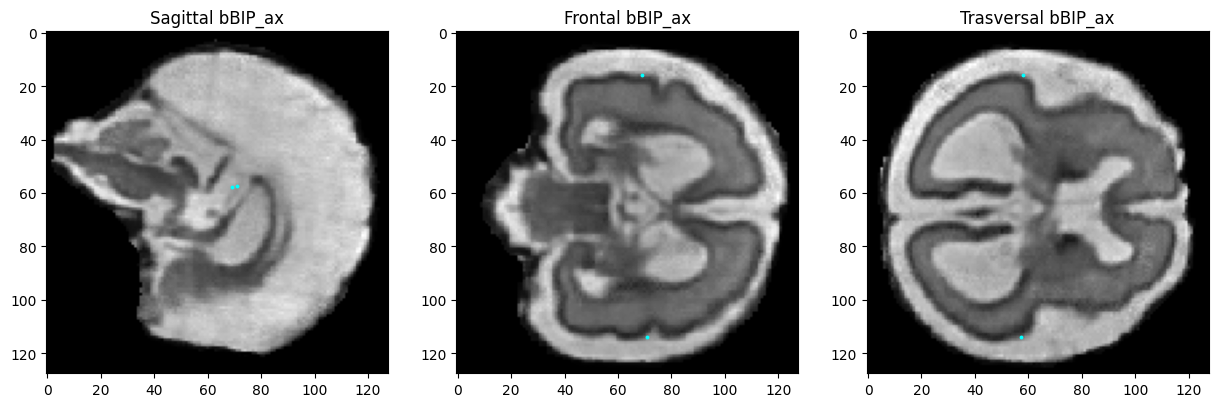

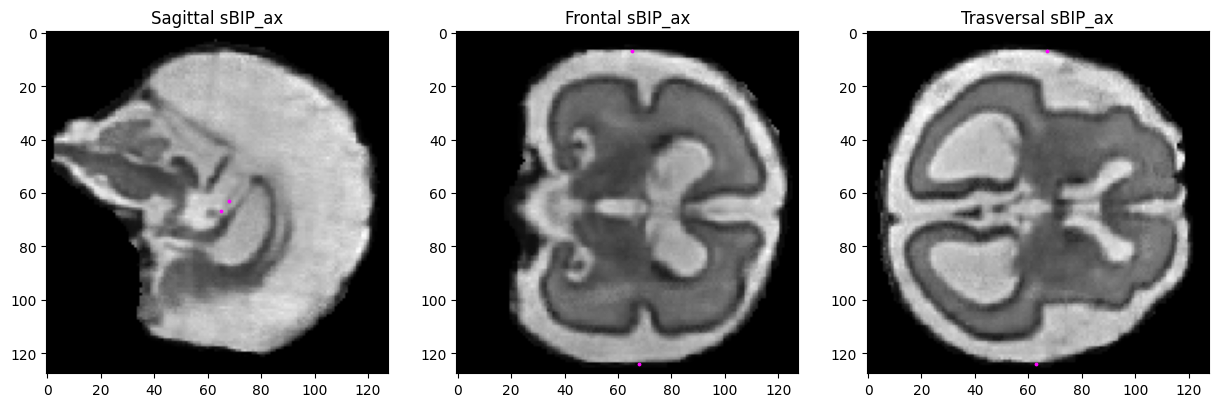

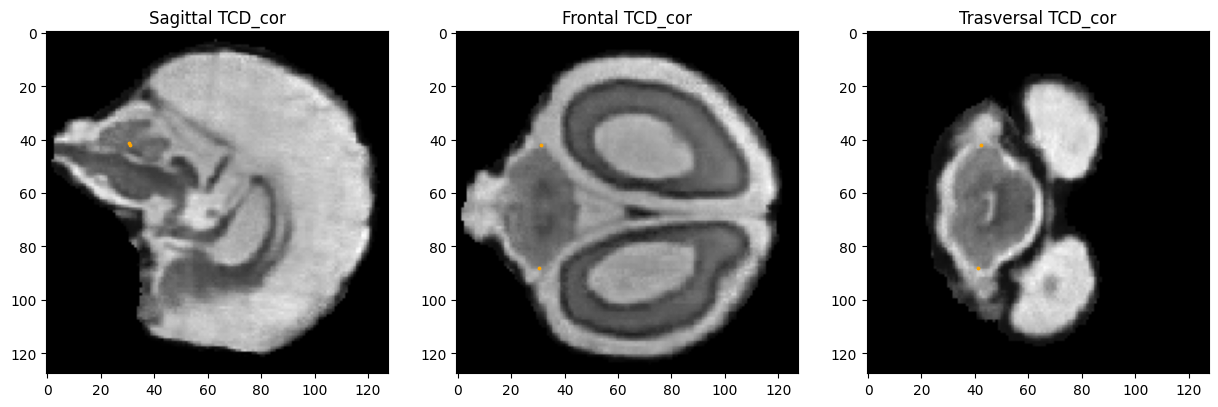

In [52]:
import matplotlib.pyplot as plt

opti= Optimization(resized_img, resized_MRI, biometry,)
opti.optimize()
biometry=opti.biometry
x_positions, y_positions, z_positions = biometry[:,0],biometry[:,1],biometry[:,2]
visualize=resized_img[0][0]
visualize=resized_MRI

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()

TO DO


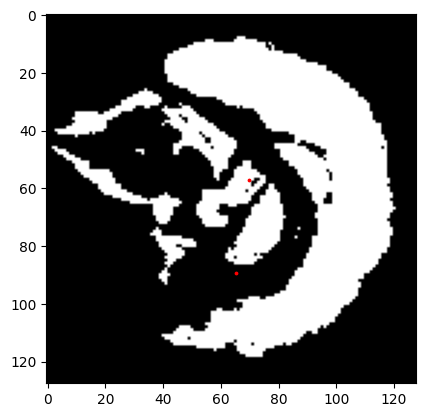

In [53]:
opti.segment_LCC()
opti.optimize_LCC()

### Testing

In [54]:
raw_img = nib.load(r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-010_rec-mial_T2w.nii.gz")
my_img = raw_img.get_fdata()

In [59]:
def reconstruct_sparse_matrix(coordinates_and_values, num_x=176, num_y=224, num_z=176):
    # Initialize a 3D matrix with zeros
    sparse_matrix = np.zeros((num_x, num_y, num_z))
    
    # Populate the matrix using the coordinates_and_values array
    for coord in coordinates_and_values:
        x, y, z, value = coord
        sparse_matrix[int(x), int(y), int(z)] = value
    
    return sparse_matrix

In [60]:
def inverse_resize(resized_array: np.array, keypoints: np.array, original_shape=(176,224,176)):
    # Calculate the inverse zoom factors
    zoom_factors = [o / t for t, o in zip(resized_array.shape, original_shape)]

    # Resize the array back to the original shape using nearest-neighbor interpolation
    original_array = zoom(resized_array, zoom_factors, order=0)  # 'order=0' for nearest-neighbor interpolation

    transformed_keypoints = np.array([(int(x * zoom_factors[0]), int(y * zoom_factors[1]), int(z * zoom_factors[2])) for x, y, z in keypoints])
    
    return original_array, transformed_keypoints

In [61]:
gerry_img = nib.load(IMG_PATH)
scotti_img = raw_img.get_fdata()
gerry_matrix=gerry_img.affine

In [62]:
data_orig, bio_orig=inverse_resize(resized_img[0][0], biometry)

In [63]:
import ants
import nibabel as nib
values=np.array([1,1,2,2,3,3,4,4,5,5])
bio_val=np.column_stack((bio_orig, values))
a=reconstruct_sparse_matrix(bio_val)
output=r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-010_bio.nii.gz"

# Create a NIfTI image
img = nib.Nifti1Image(a, affine=gerry_matrix)

nib.save(img, output)
#ants.image_write(a, output)

In [64]:
import ants
fixed = ants.image_read(r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-010_rec-mial_T2w.nii.gz")
moving = ants.image_read( r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-010_bio.nii.gz")
mywarpedimage = ants.apply_transforms( fixed=fixed, moving=moving, transformlist= r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/0GenericAffine.mat", interpolator="nearestNeighbor",
                                      whichtoinvert=[True], singleprecision=True,
                                      )
output=r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-010_gerry_bio.nii.gz"
ants.image_write(mywarpedimage, output)

In [65]:
carlo_img = nib.load(r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-010_gerry_bio.nii.gz")
conti_img = raw_img.get_fdata()

In [67]:
def load_biometry(path) -> np.array:
    bio=[]
    my_img = nib.load(path)
    nii_data = my_img.get_fdata()
    non_zero_positions = np.nonzero(nii_data)
    values = nii_data[non_zero_positions]
    x_positions, y_positions, z_positions = non_zero_positions
    coordinates_and_values = np.column_stack((x_positions, y_positions, z_positions, values))
    coordinates_and_values = coordinates_and_values[coordinates_and_values[:, -1].argsort()]
    bio.append(coordinates_and_values)
    return bio

In [68]:
testing_it = load_biometry("/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-010_gerry_bio.nii.gz")

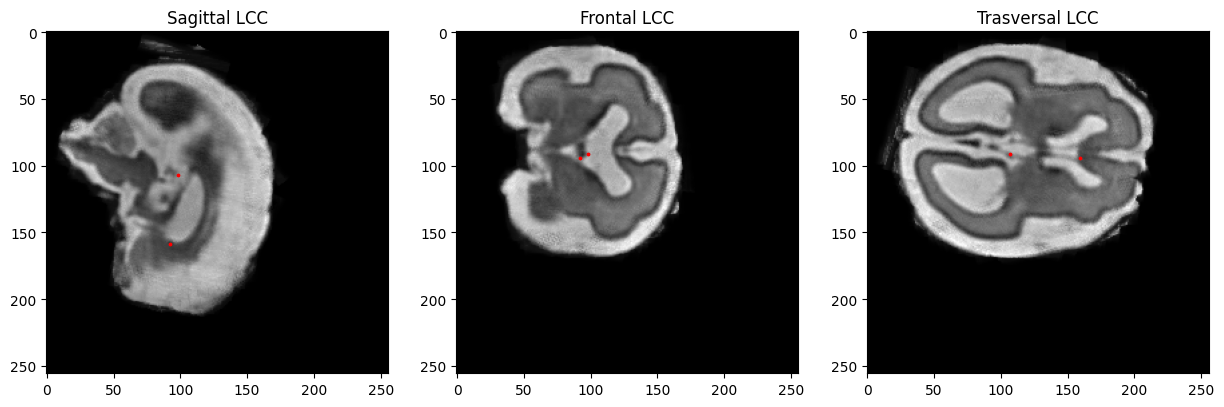

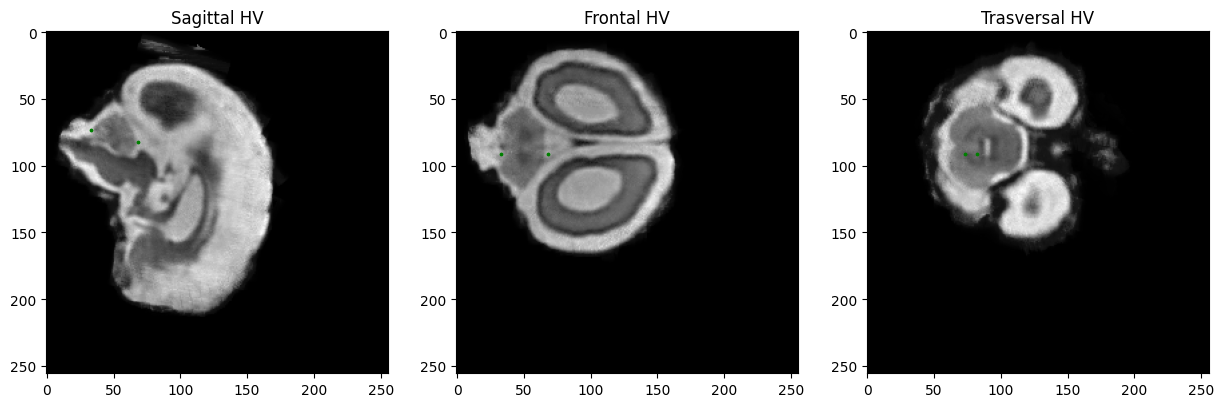

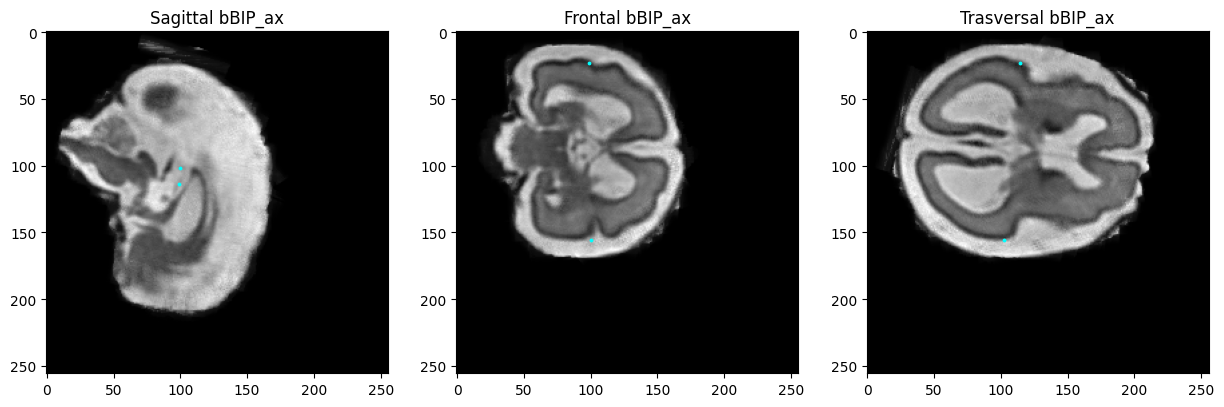

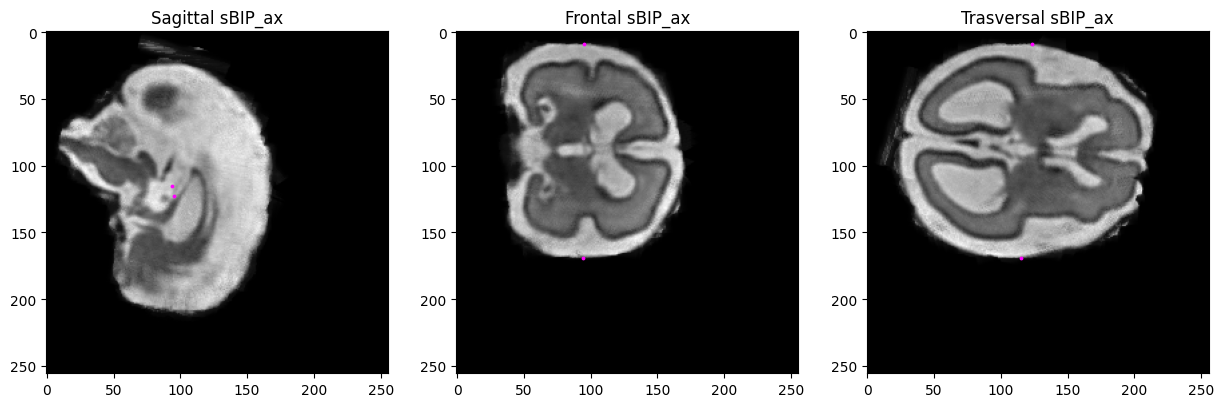

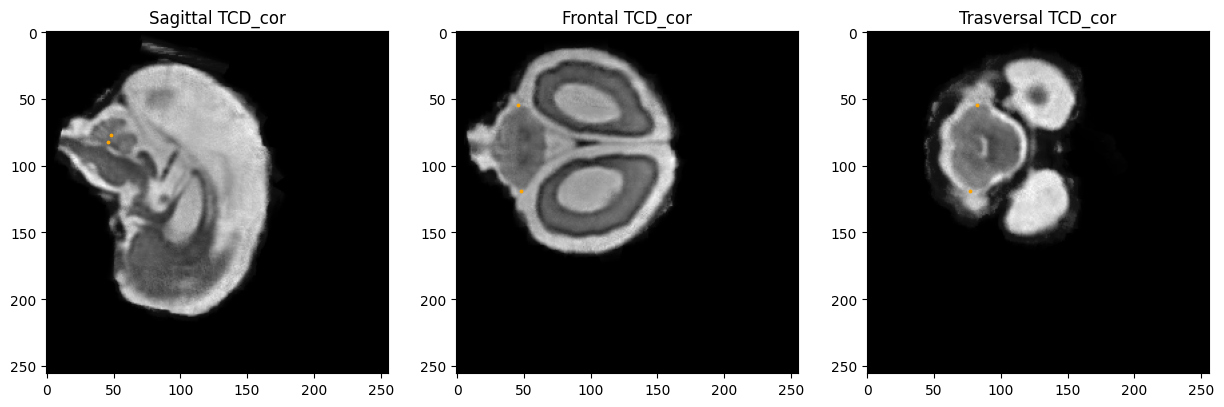

In [74]:
import matplotlib.pyplot as plt
testing_it=np.array(testing_it[0])
x_positions, y_positions, z_positions = testing_it[:,0],testing_it[:,1],testing_it[:,2]
visualize=resized_img[0][0]
visualize=my_img

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()